# CoDA × OSM Fig. 4 — **Agent updated to dataclass/tensor style**

This notebook replaces the agent with a dataclass/tensor implementation in the style you requested (transition tensor, contextual traces, uncertainty‑aware split gate, successor cloning, optional merge). It preserves all plotting cells (ring graphs, Fig. 4i/4j bars) and closes the loop first↔last in ring plots.

**What changed**
- New `CoDAAgent2US` + `CoDAConfig2US` and a minimal env `LinearNFEnv`.
- Two‑US prospective (`4`,`5`) with Beta posterior/Wilson LCB gating + presence/exposure gates.
- Splits clone **successors** and rewires `cue→s′` to `cue→clone(s′)`; reuse clones; optional merge.
- Functions `run_episode`, `encode_sequence`, and `near_far_corr` keep the previous notebook API.

In [1]:

import numpy as np
import random
from dataclasses import dataclass, field
from typing import Dict, List, Tuple, Set, Optional
import matplotlib.pyplot as plt
from matplotlib.patches import FancyArrowPatch, Circle

random.seed(0); np.random.seed(0)


In [2]:

# Sun et al. near/far observation codes
near = [1,1,1,1,1,1, 2,2,2,2, 1,1,1, 4, 6, 1,1,1, 5,5, 1,1, 7, 0,0,0]
far  = [1,1,1,1,1,1, 3,3,3,3, 1,1,1, 4,4, 1,1,1, 5, 6, 1,1, 7, 0,0,0]

# OSM analysis windows (indices along the sequences)
preR1_idx = list(range(10,13))   # before R1 visual
preR2_idx = list(range(15,18))   # before R2 visual

def block_indices(rows, cols): return [(r,c) for r in rows for c in cols]
offdiag_pairs     = block_indices(preR1_idx, preR2_idx) + block_indices(preR2_idx, preR1_idx)
same_preR1_pairs  = block_indices(preR1_idx, preR1_idx)
same_preR2_pairs  = block_indices(preR2_idx, preR2_idx)


In [ ]:

# ===================== CoDA (array-based, 2-US; uncertainty-aware) =====================

# --- Uncertainty helpers ---
try:
    from mpmath import betainc, erfcinv
    _HAS_MPMATH = True
except Exception:
    _HAS_MPMATH = False

def posterior_prob_p_greater_than(theta: float, success: float, failure: float,
                                  alpha0: float=0.5, beta0: float=0.5) -> float:
    if not _HAS_MPMATH:
        return 0.0
    a = alpha0 + max(0.0, float(success))
    b = beta0 + max(0.0, float(failure))
    cdf = betainc(a, b, 0, theta, regularized=True)
    return float(1.0 - cdf)

def wilson_lower_bound(phat: float, n: float, confidence: float=0.95) -> float:
    if n <= 0:
        return 0.0
    if _HAS_MPMATH:
        z = float((2.0**0.5) * erfcinv(2*(1.0-confidence)))
    else:
        z = 1.6448536269514722
    denom = 1.0 + (z*z)/n
    center = phat + (z*z)/(2.0*n)
    adj = z * ((phat*(1.0-phat) + (z*z)/(4.0*n))/n)**0.5
    return (center - adj)/denom

# --- core tensor helpers ---
def _ensure_shape_3d(arr: np.ndarray, new_shape: Tuple[int,int,int]) -> np.ndarray:
    if arr is None:
        return np.zeros(new_shape, dtype=float)
    S_old, A_old, S2_old = arr.shape
    S, A, S2 = new_shape
    out = np.zeros(new_shape, dtype=float)
    out[:S_old, :A_old, :S2_old] = arr
    return out

def normalize_transition_counts(counts: np.ndarray, eps: float=1e-12) -> np.ndarray:
    probs = counts.astype(float, copy=True)
    denom = probs.sum(axis=2, keepdims=True)
    denom[denom < eps] = 1.0
    probs /= denom
    return probs

def get_action_successors_from_counts(counts: np.ndarray, s: int, a: int):
    if counts.size == 0:
        return []
    succ_mask = counts[s, a] > 0
    return list(np.where(succ_mask)[0])

# --- Minimal env for near/far ---
@dataclass
class LinearNFEnv:
    n_base_states: int
    reset_symbols: Tuple[int,...] = (0,)
    clone_dict: Dict[int, int] = field(default_factory=dict)          # clone_id -> parent_sprime
    reverse_clone_dict: Dict[int, int] = field(default_factory=dict)  # parent_sprime -> clone_id
    rewarded_terminals: List[int] = field(default_factory=list)
    unrewarded_terminals: List[int] = field(default_factory=list)
    def __post_init__(self):
        self.valid_actions = {s: [0] for s in range(self.n_base_states)}  # one action
        self.num_unique_states = self.n_base_states
    def add_clone_dict(self, clone_id: int, successor: int):
        self.clone_dict[clone_id] = successor
    def add_reverse_clone_dict(self, new_clone: int, successor: int):
        self.reverse_clone_dict[successor] = new_clone

# --- Config ---
@dataclass
class CoDAConfig2US:
    gamma: float = 0.9
    lam: float = 0.8
    theta_split: float = 0.9
    theta_merge: float = 0.5
    n_threshold: int = 10
    eps: float = 1e-9
    min_presence_episodes: float = 5.0
    min_effective_exposure: float = 20.0
    confidence: float = 0.95
    alpha0: float = 0.5
    beta0: float = 0.50
    # forgetting
    count_decay: float = 1.0
    trace_decay: float = 1.0
    retro_decay: float = 1.0
    # task
    us_values: Tuple[int,int] = (4,5)   # R1 visual, R2 visual
    reset_symbols: Tuple[int,...] = (0,)

# --- Agent ---
@dataclass
class CoDAAgent2US:
    env: LinearNFEnv
    cfg: CoDAConfig2US = field(default_factory=CoDAConfig2US)

    # dynamics
    n_actions: int = field(init=False)
    n_states: int  = field(init=False)
    transition_counts: np.ndarray = field(init=False)
    transition_probs:  np.ndarray = field(init=False)

    # per-state metadata
    obs_of_state: List[int] = field(init=False)
    state_path: Dict[int, Optional[str]] = field(default_factory=dict, init=False)  # None/'R1'/'R2'
    obs_to_state_ids: Dict[int, List[int]] = field(default_factory=dict, init=False)

    # accumulators
    co_occ: np.ndarray = field(init=False)        # [S,K], K=len(us_values)
    exposure: np.ndarray = field(init=False)      # [S]
    presence_episodes: np.ndarray = field(init=False)  # [S]

    # retrospective EMA (per US)
    cs_us_presence: np.ndarray = field(init=False) # [K,S]
    us_episode_ema: np.ndarray  = field(init=False) # [K]

    # cues/clones
    salient_cues: Set[int] = field(default_factory=set, init=False)
    cue_to_clones: Dict[int, List[int]] = field(default_factory=dict, init=False)
    clone_parent: Dict[int, int] = field(default_factory=dict, init=False)
    created_by_cue: Dict[int, int] = field(default_factory=dict, init=False)
    cue_preferred_us: Dict[int, int] = field(default_factory=dict, init=False)

    def __post_init__(self):
        self.n_actions = 1
        self.n_states = int(self.env.num_unique_states)
        self.transition_counts = np.zeros((self.n_states, self.n_actions, self.n_states), dtype=float)
        self.transition_probs  = normalize_transition_counts(self.transition_counts)

        # base mapping: obs==sid initially
        self.obs_of_state = list(range(self.n_states))
        self.obs_to_state_ids = {o: [o] for o in range(self.n_states)}
        self.state_path = {s: None for s in range(self.n_states)}

        K = len(self.cfg.us_values)
        self.co_occ = np.zeros((self.n_states, K), dtype=float)
        self.exposure = np.zeros((self.n_states,), dtype=float)
        self.presence_episodes = np.zeros((self.n_states,), dtype=float)

        self.cs_us_presence = np.zeros((K, self.n_states), dtype=float)
        self.us_episode_ema = np.zeros((K,), dtype=float)

    # --- growth ---
    def _maybe_grow(self, needed_state_index: int):
        if needed_state_index < self.n_states:
            return
        new_n = needed_state_index + 1
        self.transition_counts = _ensure_shape_3d(self.transition_counts, (new_n, self.n_actions, new_n))
        self.transition_probs  = normalize_transition_counts(self.transition_counts)

        K = len(self.cfg.us_values)
        # per-state arrays
        new_co = np.zeros((new_n, K), dtype=float); new_co[:self.co_occ.shape[0], :]=self.co_occ; self.co_occ=new_co
        new_ex = np.zeros((new_n,), dtype=float);   new_ex[:self.exposure.shape[0]]=self.exposure; self.exposure=new_ex
        new_pr = np.zeros((new_n,), dtype=float);   new_pr[:self.presence_episodes.shape[0]]=self.presence_episodes; self.presence_episodes=new_pr
        new_rc = np.zeros((K, new_n), dtype=float); new_rc[:, :self.cs_us_presence.shape[1]]=self.cs_us_presence; self.cs_us_presence=new_rc

        # bookkeeping arrays
        for sid in range(self.n_states, new_n):
            self.obs_of_state.append(self.obs_of_state[-1] if self.obs_of_state else sid)
            self.state_path[sid] = None
        self.n_states = new_n

    def _select_state_for_obs(self, obs: int, context: Optional[str]) -> int:
        cands = self.obs_to_state_ids.get(obs, [])
        if context is not None:
            for sid in cands:
                if self.state_path.get(sid) == context:
                    return sid
        for sid in cands:
            if self.state_path.get(sid) is None:
                return sid
        return cands[0] if cands else 0

    # --- main episode API (keeps old signature) ---
    def run_episode(self, obs_seq: List[int], learn: bool=True) -> List[int]:
        context = None
        latent_seq = []
        visited = set()
        for obs in obs_seq:
            sid = self._select_state_for_obs(obs, context)
            latent_seq.append(sid); visited.add(sid)
            if sid in self.salient_cues:
                context = 'R1' if self.cue_preferred_us[sid]==self.cfg.us_values[0] else 'R2'
            if obs in self.cfg.reset_symbols:
                context = None

        if not learn:
            return latent_seq

        # decay retrospectives (optional)
        if self.cfg.retro_decay < 1.0:
            self.cs_us_presence *= self.cfg.retro_decay
            self.us_episode_ema *= self.cfg.retro_decay

        # transitions
        for t in range(len(latent_seq)-1):
            s, sp = latent_seq[t], latent_seq[t+1]
            self._maybe_grow(max(s, sp))
            self.transition_counts[s, 0, sp] += 1.0

        # presence (once per episode per state)
        for s in visited:
            self.presence_episodes[s] += 1.0

        # contextual eligibility for per‑US co‑occ
        K = len(self.cfg.us_values)
        us_to_k = {u:k for k,u in enumerate(self.cfg.us_values)}
        for t, obs in enumerate(obs_seq):
            if obs in us_to_k:
                k = us_to_k[obs]
                e = np.zeros((self.n_states,), dtype=float)
                for tau in range(t+1):
                    sid = latent_seq[tau]
                    e *= (self.cfg.gamma * self.cfg.lam)
                    e[sid] += 1.0
                self.co_occ[:, k] += e
                self.exposure += e

        # retrospective EMA by US presence in episode
        snap = np.zeros((self.n_states,), dtype=float); 
        for s in visited: snap[s] = 1.0
        for k,u in enumerate(self.cfg.us_values):
            if any(o==u for o in obs_seq):
                self.cs_us_presence[k, :self.n_states] += snap[:self.n_states]
                self.us_episode_ema[k] += 1.0

        self.transition_probs = normalize_transition_counts(self.transition_counts)
        # split & optional merge
        new_cues = self._maybe_split()
        if new_cues: self.transition_probs = normalize_transition_counts(self.transition_counts)
        self._maybe_merge()
        return latent_seq

    # --- contingencies ---
    def prospective_full(self) -> np.ndarray:
        tot = self.co_occ.sum(axis=1) + self.cfg.eps
        return (self.co_occ / tot[:,None])  # [S,K]
    def prospective(self) -> np.ndarray:
        return self.prospective_full().max(axis=1)
    def retrospective(self) -> np.ndarray:
        rc = np.zeros((self.n_states,), dtype=float)
        for k in range(len(self.cfg.us_values)):
            denom = max(self.us_episode_ema[k], self.cfg.eps)
            rc = np.maximum(rc, self.cs_us_presence[k] / denom)
        return rc

    # --- splitting/merging ---
    def _maybe_split(self) -> List[int]:
        P = self.prospective_full()
        tot = self.co_occ.sum(axis=1)
        exposure = self.exposure
        new_cues = []
        for s in range(self.n_states):
            if tot[s] < self.cfg.n_threshold:               continue
            if self.presence_episodes[s] < self.cfg.min_presence_episodes: continue
            if exposure[s] < self.cfg.min_effective_exposure:              continue
            if s in self.salient_cues:                      continue
            k_star = int(np.argmax(P[s])); u_star = self.cfg.us_values[k_star]
            phat = float(P[s, k_star])
            success = self.co_occ[s, k_star]; failure = max(tot[s]-success, 0.0)
            post = posterior_prob_p_greater_than(self.cfg.theta_split, success, failure,
                                                 self.cfg.alpha0, self.cfg.beta0)
            if post == 0.0:
                lb = wilson_lower_bound(phat, max(tot[s], 1e-9), confidence=self.cfg.confidence)
                pass_test = (lb > self.cfg.theta_split)
            else:
                pass_test = (post >= self.cfg.confidence)
            if pass_test:
                label = 'R1' if u_star==self.cfg.us_values[0] else 'R2'
                clones = self._split_state(s, label)
                if clones:
                    self.salient_cues.add(s)
                    self.cue_preferred_us[s] = u_star
                    self.cue_to_clones[s] = list(clones)
                    new_cues.append(s)
        return new_cues

    def _split_state(self, cue_s: int, path_label: str) -> List[int]:
        clones = []
        seen_successors = set()
        a = 0
        s_primes = get_action_successors_from_counts(self.transition_counts, cue_s, a)
        for sprime in s_primes:
            if sprime in seen_successors: continue
            seen_successors.add(sprime)
            obs = self.obs_of_state[sprime]
            # find existing path-specific clone for this obs
            existing = None
            for sid in self.obs_to_state_ids.get(obs, []):
                if self.state_path.get(sid) == path_label:
                    existing = sid; break
            if existing is None:
                clone_id = self.n_states
                self._maybe_grow(clone_id)
                self.obs_of_state[clone_id] = obs
                self.obs_to_state_ids.setdefault(obs, []).append(clone_id)
                self.state_path[clone_id] = path_label
                self.env.add_clone_dict(clone_id, successor=sprime)
                self.env.add_reverse_clone_dict(new_clone=clone_id, successor=sprime)
                self.clone_parent[clone_id] = sprime
                self.created_by_cue[clone_id] = cue_s
                clones.append(clone_id)
                self.transition_counts[clone_id, :, :] = self.transition_counts[sprime, :, :]
                target = clone_id
            else:
                target = existing
            cnt = self.transition_counts[cue_s, a, sprime]
            if cnt > 0:
                self.transition_counts[cue_s, a, sprime] = 0.0
                self.transition_counts[cue_s, a, target] += cnt
        return clones

    def _maybe_merge(self) -> List[int]:
        merged = []
        P = self.prospective_full(); rc = self.retrospective()
        for cue in list(self.salient_cues):
            u_star = self.cue_preferred_us.get(cue, self.cfg.us_values[0])
            k_star = list(self.cfg.us_values).index(u_star)
            info = float(P[cue, k_star]) * float(rc[cue])
            # mass from cue to its clones
            edge_mass = sum(float(self.transition_probs[cue, 0, cl])
                            for cl in self.cue_to_clones.get(cue, []) if cl < self.transition_probs.shape[2])
            if (info < self.cfg.theta_merge) or (edge_mass < 1e-6):
                self._merge_cue(cue)
                self.salient_cues.remove(cue)
                self.cue_to_clones.pop(cue, None)
                self.cue_preferred_us.pop(cue, None)
                merged.append(cue)
        self.transition_probs = normalize_transition_counts(self.transition_counts)
        return merged

    def _merge_cue(self, cue: int):
        clones = list(self.cue_to_clones.get(cue, []))
        for clone_id in clones:
            if clone_id >= self.n_states or clone_id not in self.clone_parent: 
                continue
            sprime = self.clone_parent[clone_id]
            cnt = self.transition_counts[cue, 0, clone_id]
            if cnt > 0:
                self.transition_counts[cue, 0, clone_id] = 0.0
                self.transition_counts[cue, 0, sprime] += cnt
            inbound = self.transition_counts[:, :, clone_id]
            if inbound.sum() > 0:
                self.transition_counts[:, :, sprime] += inbound
                self.transition_counts[:, :, clone_id] = 0.0
            self.transition_counts[clone_id, :, :] = 0.0
            # cleanup mapping
            self.env.clone_dict.pop(clone_id, None)
            obs = self.obs_of_state[clone_id]
            if obs in self.obs_to_state_ids and clone_id in self.obs_to_state_ids[obs]:
                self.obs_to_state_ids[obs].remove(clone_id)
            self.state_path[clone_id] = None
        # rebuild reverse map
        self.env.reverse_clone_dict = {par:cl for cl, par in self.env.clone_dict.items()}

    # --- encoders used by plotting/metrics ---
    def encode_sequence(self, obs_seq: List[int]) -> np.ndarray:
        lat = self.run_episode(obs_seq, learn=False)
        S = self.n_states
        X = np.zeros((len(lat), S), dtype=float)
        for t,sid in enumerate(lat): X[t,sid]=1.0
        return X

    def near_far_corr(self, near_seq, far_seq) -> np.ndarray:
        A=self.encode_sequence(near_seq); B=self.encode_sequence(far_seq)
        C=np.zeros((A.shape[0], B.shape[0]))
        for i in range(A.shape[0]):
            for j in range(B.shape[0]):
                a=A[i]; b=B[j]
                if np.allclose(a,0) or np.allclose(b,0): C[i,j]=0.0; continue
                a0=a-a.mean(); b0=b-b.mean()
                den=(np.linalg.norm(a0)*np.linalg.norm(b0))
                C[i,j]=(a0@b0)/den if den>0 else 0.0
        return C

    def get_T(self) -> np.ndarray:
        return self.transition_probs

    def get_PC_RC(self) -> Tuple[np.ndarray, np.ndarray]:
        return self.prospective(), self.retrospective()


In [4]:

# ---- Training / evaluation setup ----
N_RUNS   = 6
SESSIONS = 9
TRIALS_PER_SESSION = 80
THRESH   = 0.3

def block_mean(C, pairs): 
    return float(np.mean([C[i,j] for (i,j) in pairs])) if pairs else np.nan

rng = np.random.default_rng(123)
all_final_blocks=[]; all_time_to_thr=[]; mat_by_session={s:[] for s in [1,3,4,9]}
checkpoint_sessions=[1,3,4,9]; demo_checkpoints={}

for run in range(N_RUNS):
    symbols = sorted(set(near)|set(far))
    env = LinearNFEnv(n_base_states=max(symbols)+1, reset_symbols=(0,))
    agent = CoDAAgent2US(env, cfg=CoDAConfig2US(
        gamma=0.9, lam=0.8, theta_split=0.9, theta_merge=0.5,
        n_threshold=5, min_presence_episodes=3, min_effective_exposure=10.0,
        confidence=0.95, alpha0=0.5, beta0=0.5, reset_symbols=(0,)
    ))

    tt={'offdiag':None,'preR2':None,'preR1':None}
    for session in range(1, SESSIONS+1):
        episodes = [near]*(TRIALS_PER_SESSION//2) + [far]*(TRIALS_PER_SESSION//2)
        rng.shuffle(episodes)
        for ep in episodes:
            agent.run_episode(ep, learn=True)

        C = agent.near_far_corr(near, far)
        if session in mat_by_session: mat_by_session[session].append(C)

        if run==0 and session in checkpoint_sessions:
            # copy agent (lightweight snapshot)
            demo_checkpoints[session] = agent

        b_off=block_mean(C, offdiag_pairs); b_r2=block_mean(C, same_preR2_pairs); b_r1=block_mean(C, same_preR1_pairs)
        if tt['offdiag'] is None and b_off<THRESH: tt['offdiag']=session
        if tt['preR2']  is None and b_r2<THRESH:  tt['preR2']=session
        if tt['preR1']  is None and b_r1<THRESH:  tt['preR1']=session

    C_final = agent.near_far_corr(near, far)
    all_final_blocks.append((run, b_off, b_r2, b_r1))
    def norm(x): return x/SESSIONS if x is not None else np.nan
    all_time_to_thr.append((run, norm(tt['offdiag']), norm(tt['preR2']), norm(tt['preR1'])))

blocks_df = (np.array(all_final_blocks)[:,1:]).mean(axis=0)
times_df  = (np.array(all_time_to_thr)[:,1:])


In [5]:

def canonical_latents(agent, seq):
    lat = agent.run_episode(seq, learn=False)
    out=[]
    for t,(obs,sid) in enumerate(zip(seq, lat)):
        if obs==0: break
        out.append((t, obs, sid, agent.state_path.get(sid, None)))
    return out

def ring_positions(T: int, r_base=1.0, r_near=1.12, r_far=0.88, start_angle=np.pi/2):
    pos_by_t = {}
    for t in range(T):
        theta = start_angle - 2*np.pi*(t / max(T,1))
        pos_by_t[t] = {'theta': theta,
                       'base': (r_base*np.cos(theta), r_base*np.sin(theta)),
                       'R1':   (r_near*np.cos(theta), r_near*np.sin(theta)),
                       'R2':   (r_far*np.cos(theta),  r_far*np.sin(theta))}
    return pos_by_t

def build_color_assignments(near_lat, far_lat):
    # OSM-like block coloring
    colors={}
    col_magenta='#cf4ea6'; col_green='#7cc578'; col_blue='#3b6ea8'; col_grey='#9c9c9c'; col_black='#111'
    def set_default(lat_seq):
        for (t,obs,sid,path) in lat_seq:
            ring='base' if path is None else path
            colors[(t,ring)] = col_grey
    set_default(near_lat); set_default(far_lat)
    for t in [6,7,8,9]: colors[(t,'base')] = col_blue
    for t in [10,11,12]: 
        colors[(t,'base')]=col_magenta; colors[(t,'R1')]=col_magenta; colors[(t,'R2')]=col_magenta
    for t in [15,16,17]:
        colors[(t,'base')]=col_green; colors[(t,'R1')]=col_green; colors[(t,'R2')]=col_green
    colors[(22,'base')] = colors[(22,'R1')] = colors[(22,'R2')] = col_black
    return colors

def draw_cscg_style_ring(ax, agent, title=None, close_loop=True):
    near_lat = canonical_latents(agent, near)
    far_lat  = canonical_latents(agent, far)
    T = max(len(near_lat), len(far_lat))
    pos = ring_positions(T)
    node_colors = build_color_assignments(near_lat, far_lat)

    # uniform gray edges
    def draw_edges(lat_seq, z=1):
        for i in range(len(lat_seq)-1):
            t, _, _, p  = lat_seq[i]
            t2,_, _, p2 = lat_seq[i+1]
            r1='base' if p  is None else p
            r2='base' if p2 is None else p2
            x1,y1 = pos[t][r1]; x2,y2 = pos[t2][r2]
            ax.add_patch(FancyArrowPatch((x1,y1),(x2,y2), arrowstyle='-|>', mutation_scale=6,
                                         lw=1.2, color='#6a6a6a', alpha=0.9, shrinkA=2, shrinkB=2, zorder=z))
        if close_loop and len(lat_seq)>=2:
            t0,_,_,p0 = lat_seq[0]
            tL,_,_,pL = lat_seq[-1]
            r0='base' if p0 is None else p0; rL='base' if pL is None else pL
            x1,y1 = pos[tL][rL]; x2,y2 = pos[t0][r0]
            ax.add_patch(FancyArrowPatch((x1,y1),(x2,y2), arrowstyle='-|>', mutation_scale=6,
                                         lw=1.2, color='#6a6a6a', alpha=0.9, shrinkA=2, shrinkB=2, zorder=z))

    def draw_nodes(lat_seq, z=3):
        for (t,obs,sid,path) in lat_seq:
            ring='base' if path is None else path
            x,y = pos[t][ring]
            face = node_colors.get((t,ring), '#bfbfbf')
            ax.add_patch(Circle((x,y), radius=0.045, facecolor=face,
                                edgecolor='#4a4a4a', lw=0.7, alpha=0.98, zorder=z))

    draw_edges(near_lat,1); draw_edges(far_lat,1)
    draw_nodes(far_lat,3); draw_nodes(near_lat,4)

    ax.set_aspect('equal'); ax.axis('off')
    ax.set_xlim(-1.55,1.55); ax.set_ylim(-1.55,1.55)
    if title: ax.set_title(title)


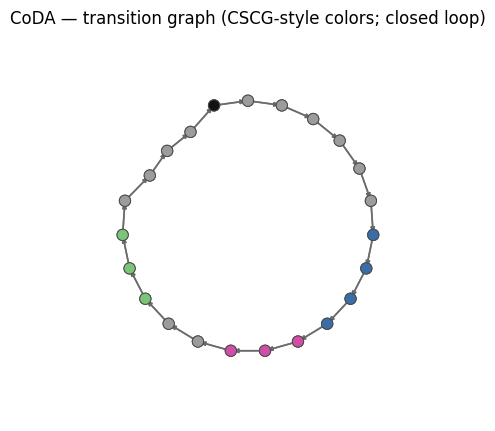

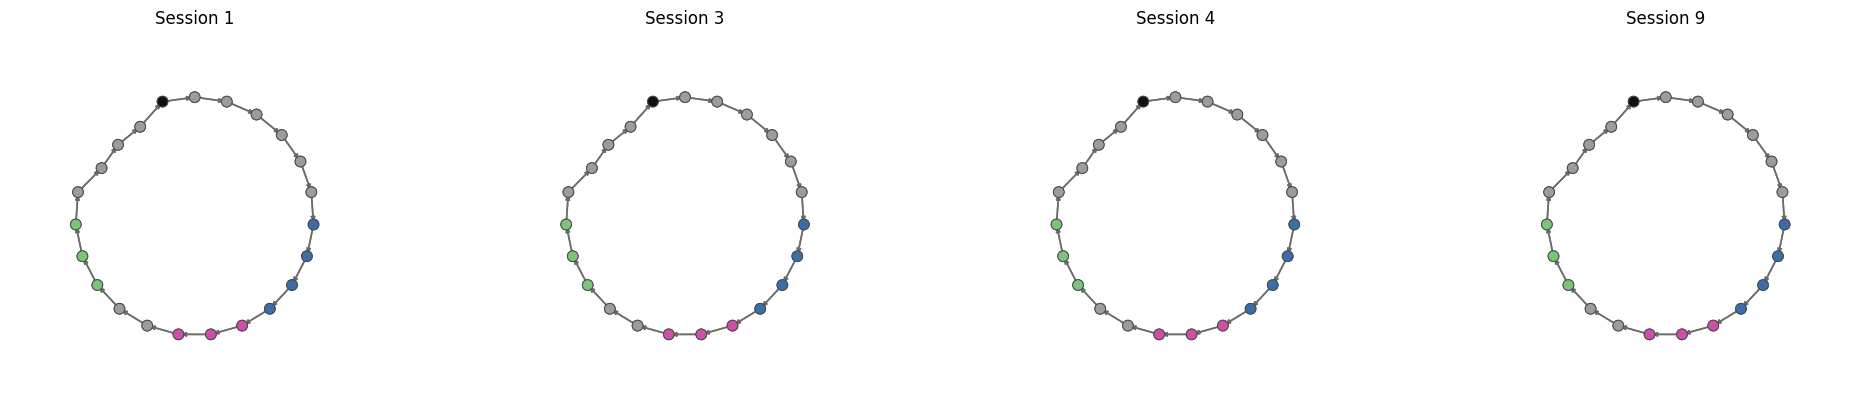

In [6]:

final_session = max(demo_checkpoints.keys())
fig, ax = plt.subplots(figsize=(6.8,4.2), constrained_layout=True)
draw_cscg_style_ring(ax, demo_checkpoints[final_session], title="CoDA — transition graph (CSCG-style colors; closed loop)")
plt.show()

fig, axes = plt.subplots(1, len(demo_checkpoints), figsize=(4.9*len(demo_checkpoints),4.0), constrained_layout=True)
for ax, s in zip(axes, sorted(demo_checkpoints.keys())):
    draw_cscg_style_ring(ax, demo_checkpoints[s], title=f"Session {s}")
plt.show()


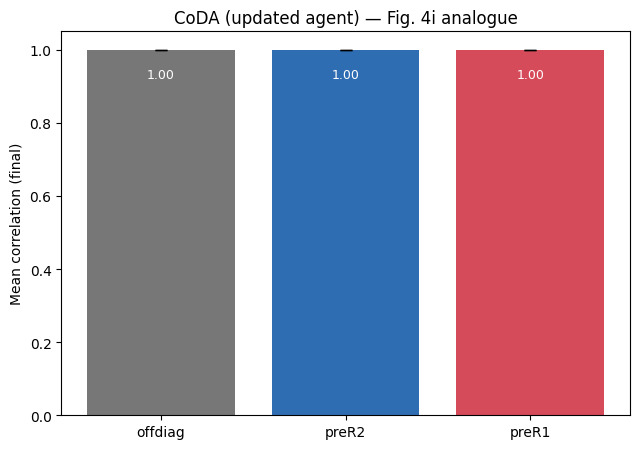

/var/folders/s0/k9fg8kp94xl307gydfsd9gf00000gq/T/ipykernel_23644/1651252626.py:23: RuntimeWarning: Mean of empty slice
  means_t = np.nanmean(times_df, axis=0); ses_t = np.nanstd(times_df, axis=0, ddof=1)/np.sqrt(max(1, times_df.shape[0]))
/opt/anaconda3/envs/coda-minigrid/lib/python3.10/site-packages/numpy/lib/_nanfunctions_impl.py:2019: RuntimeWarning: Degrees of freedom <= 0 for slice.
  var = nanvar(a, axis=axis, dtype=dtype, out=out, ddof=ddof,


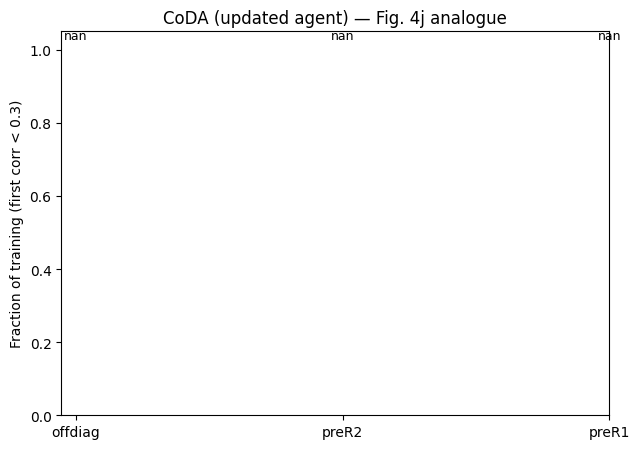

In [7]:

# Compute run means from the arrays we stored
means = np.nanmean(np.array(all_final_blocks)[:,1:], axis=0)
ses   = np.nanstd(np.array(all_final_blocks)[:,1:], axis=0, ddof=1) / np.sqrt(max(1, len(all_final_blocks)))

labels = ['offdiag','preR2','preR1']
x = np.arange(len(labels)); y = means; yerr = ses

fig, ax = plt.subplots(figsize=(6.5,4.6))
bars = ax.bar(x, y, yerr=yerr, capsize=4, color=['#777','#2f6db3','#d64b5a'])
ax.set_xticks(x); ax.set_xticklabels(labels)
ax.set_ylim(0, 1.05)
ax.set_ylabel("Mean correlation (final)")
ax.set_title("CoDA (updated agent) — Fig. 4i analogue")

for i, (b, val) in enumerate(zip(bars, y)):
    if val > 0.85:
        ax.text(b.get_x()+b.get_width()/2, val-0.05, f"{val:.2f}", ha='center', va='top', color='white', fontsize=9)
    else:
        ax.text(b.get_x()+b.get_width()/2, min(1.02, val+0.05), f"{val:.2f}", ha='center', va='bottom', fontsize=9)
fig.tight_layout(); plt.show()

# Fig. 4j analogue (normalized time to threshold)
means_t = np.nanmean(times_df, axis=0); ses_t = np.nanstd(times_df, axis=0, ddof=1)/np.sqrt(max(1, times_df.shape[0]))
disp = ['offdiag','preR2','preR1']
x = np.arange(len(disp)); y = means_t; yerr = ses_t

fig, ax = plt.subplots(figsize=(6.5,4.6))
bars = ax.bar(x, y, yerr=yerr, capsize=4, color=['#777','#2f6db3','#d64b5a'])
ax.set_xticks(x); ax.set_xticklabels(disp)
ax.set_ylim(0, 1.05)
ax.set_ylabel("Fraction of training (first corr < 0.3)")
ax.set_title("CoDA (updated agent) — Fig. 4j analogue")
for i, (b, val) in enumerate(zip(bars, y)):
    ax.text(b.get_x()+b.get_width()/2, min(1.02, val+0.05), f"{val:.2f}", ha='center', va='bottom', fontsize=9)
fig.tight_layout(); plt.show()
